# Scheduling MRI facilities
Course: EBS4043 - Computational Research Skill

In [1]:
# Load external script for helper functions
source("utils.r")

# Seed for reproducibility
set.seed(2026)

# Read data
data <- read.csv("data/ScanRecords.csv"); invisible(attach(data))
summary(data)

# Default variables
B <- 10000
alpha <- 0.05

# Split data by type
p1 <- data[data$PatientType == "Type 1", ]
p2 <- data[data$PatientType == "Type 2", ]

     Date                Time          Duration      PatientType       
 Length:565         Min.   : 8.01   Min.   :0.1513   Length:565        
 Class :character   1st Qu.:10.20   1st Qu.:0.3945   Class :character  
 Mode  :character   Median :12.66   Median :0.4776   Mode  :character  
                    Mean   :12.51   Mean   :0.5210                     
                    3rd Qu.:14.82   3rd Qu.:0.6013                     
                    Max.   :16.97   Max.   :1.3736                     

We split the data into one dataset per patient type to simplify the analysis later on.

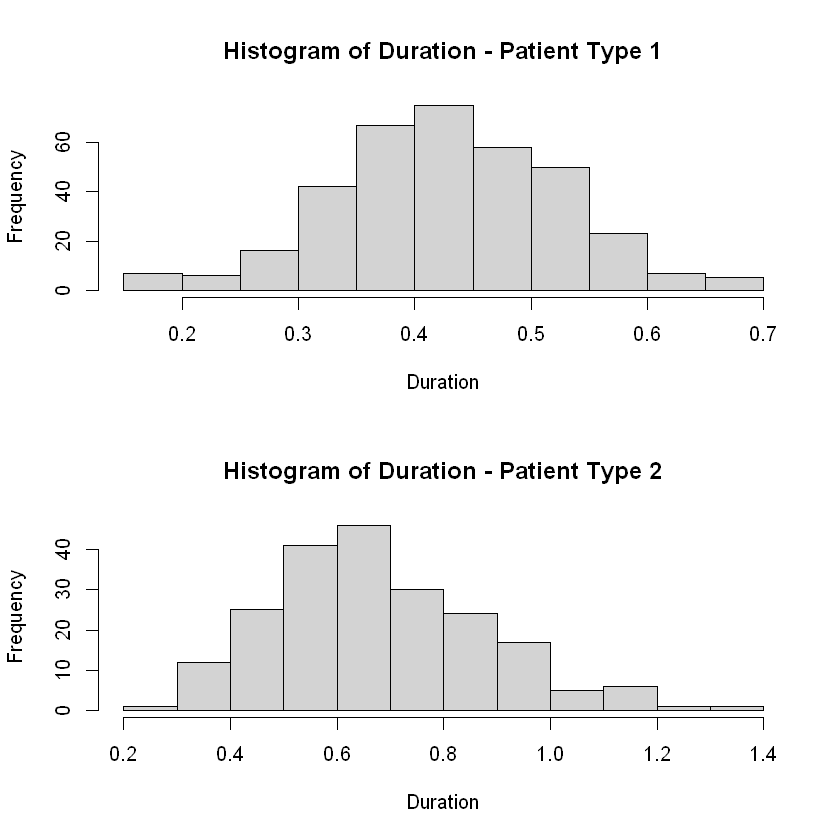

In [44]:
par(mfrow = c(2, 1), bg = "white")
hist(Duration[PatientType == "Type 1"],
     main = "Histogram of Duration - Patient Type 1",
     xlab = "Duration")

hist(Duration[PatientType == "Type 2"],
     main = "Histogram of Duration - Patient Type 2",
     xlab = "Duration")

The histogram of the duration of a treatment for patients of the second type seem to exhibit some skewedness as the right tail is visibly longer than the left tail.

The durations of the first type of patient appear to have a Normal distribution

These results could lead us to doubt whether the Bootstrap distribution of the means would correctly converge to a Normal distribution.

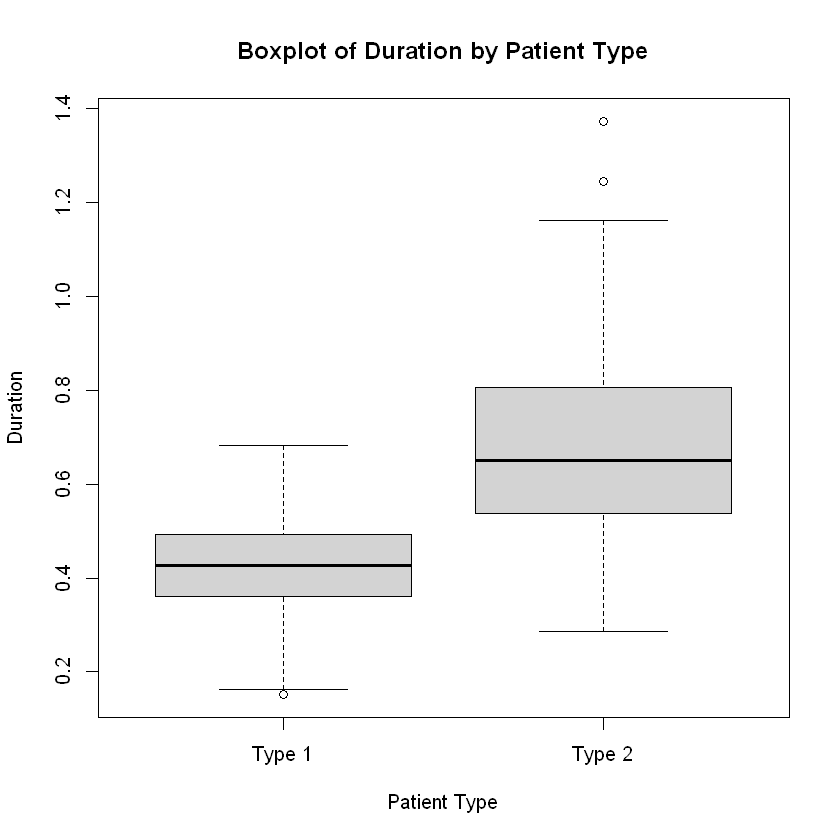

In [3]:
par(bg = "white")
boxplot(Duration ~ factor(PatientType), data = data,
        main = "Boxplot of Duration by Patient Type",
        xlab = "Patient Type")

The boxplots above show a sizable difference between the mean duration of both patient groups. In order to gain a better estimate of the mean duration of the two patient types, we make use of the bootstrap and construct confidence intervals.

## Mean of Duration - Bootstrap

The bootstrap mean for the first type of patients is $0.4286$ with a 95% confidence interval of $[0.4185, 0.4386]$ approximated by computing the 2.5% and 97.5% quantile values in the bootstrap sample.

In [4]:
p1.d <- boot.mean(B, p1$Duration)
ci(p1.d)



|      mean|        se|
|---------:|---------:|
| 0.4284861| 0.0051466|




|      |        CI|
|:-----|---------:|
|2.5%  | 0.4184652|
|97.5% | 0.4385854|

The second type of patients have a bootstrap mean duration of $0.6783$ with a 95% confidence interval of $[0.6513, 0.7054]$ approximated in the same way as the earlier confidence interval.

In [5]:
p2.d <- boot.mean(B, p2$Duration)
ci(p2.d)



|    mean|        se|
|-------:|---------:|
| 0.67831| 0.0138923|




|      |        CI|
|:-----|---------:|
|2.5%  | 0.6513444|
|97.5% | 0.7053817|

The lack of overlap between the confidence intervals of the means lead us to conclude that these population differ significantly in mean duration time

# Variance of Duration - Bootstrap

The bootstrap method can also be used to estimate other quantities than the mean. In this section, we estimate the variance of the duration of treatment for both types of patient.

In [42]:
p1.dV <- boot.var(B, p1$Duration)
p2.dV <- boot.var(B, p2$Duration)



|      mean|        se|
|---------:|---------:|
| 0.0094323| 0.0007357|


|      mean|        se|
|---------:|---------:|
| 0.0402293| 0.0041244|


Edit: A new hypothesis would be that the duration data for patients of type 2 is Gamma or Poisson distributed.

In [75]:
test.pois(p2$Duration)
test.gamma(p2$Duration)

stat,p.value
<dbl>,<dbl>
21302.83,0


stat,p.value
<dbl>,<dbl>
3.897962e+26,0.2999


We only fail to reject the test for the Gamma distribution and thus it is reasonable to expect it to have a Gamma distribution.

## Daily Patients - Bootstrap

We investigate whether the arrival times of both types of patients behave according to a Poisson distribution.

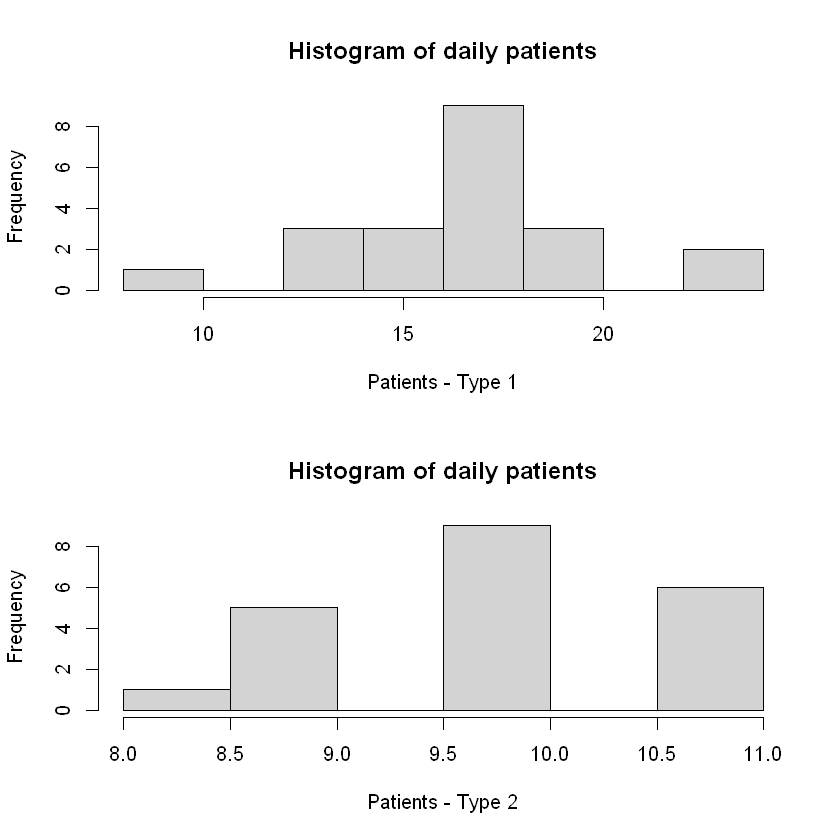

In [7]:
p1.daily <- daily(p1$Date, tab = FALSE)
p2.daily <- daily(p2$Date, tab = FALSE)

par(mfrow = c(2, 1), bg = "white")
hist(p1.daily,
     main = "Histogram of daily patients",
     xlab = "Patients - Type 1")
hist(p2.daily,
     main = "Histogram of daily patients",
     xlab = "Patients - Type 2")

It is hard to visually determine the distribution of the variables due to small sample and variability in the sample. Despite this, one can still use the bootstrap to evaluate the mean of the data.

Regarding the first type of patients, the mean number of patients per day is $16.96$ if we look at the bootstrap computations.

In [8]:
p1.day <- boot.mean(B, p1.daily)
ci(p1.day)



|     mean|        se|
|--------:|---------:|
| 16.95996| 0.6961285|




|      |       CI|
|:-----|--------:|
|2.5%  | 15.61905|
|97.5% | 18.33333|

The mean number of patients of type 2 per day is $9.95$ according to the bootstrap.

In [9]:
p2.day <- boot.mean(B, p2.daily)
ci(p2.day)



|     mean|        se|
|--------:|---------:|
| 9.952767| 0.1850547|




|      |        CI|
|:-----|---------:|
|2.5%  |  9.571429|
|97.5% | 10.333333|

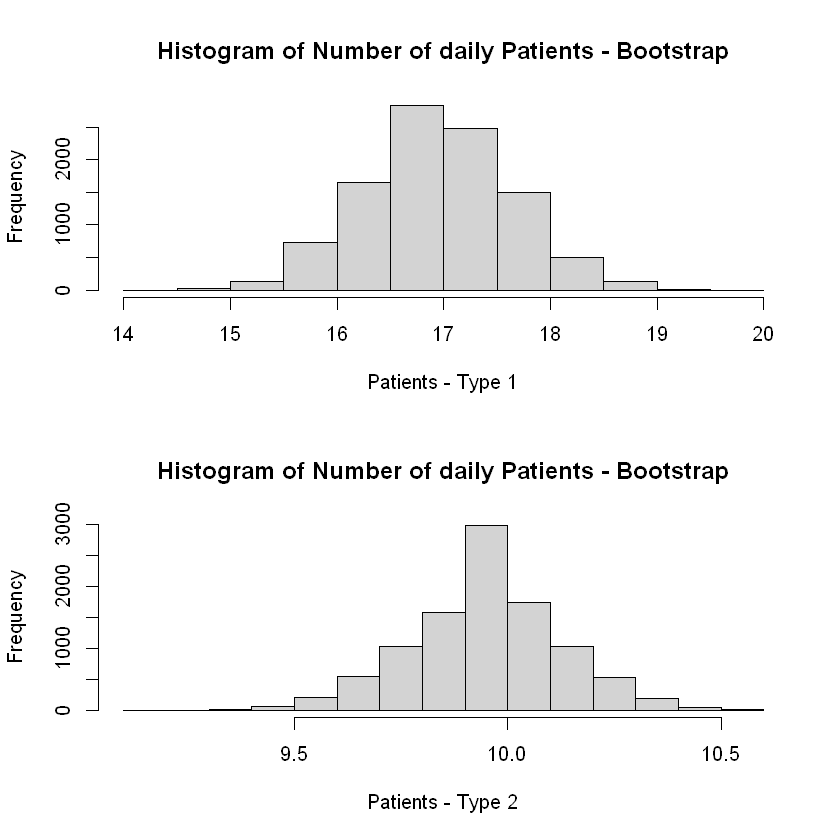

In [10]:
par(mfrow = c(2, 1), bg = "white")
hist(p1.day,
     main = "Histogram of Number of daily Patients - Bootstrap",
     xlab = "Patients - Type 1")
hist(p2.day,
     main = "Histogram of Number of daily Patients - Bootstrap",
     xlab = "Patients - Type 2")

In [11]:
test.pois(p1.daily)
test.pois(p2.daily)

stat,p.value
<dbl>,<dbl>
15.94691,0.4694


stat,p.value
<dbl>,<dbl>
23.90034,0.1685


## Interarrival times

It is difficult to establish clearly whether the arrival data is Poisson distributed due to the size of the sample $(n = 21)$, however we know that if the arrival data was Poisson distributed, then the interarrival data (time between two consecutive arrivals) would be Exponentially distributed.

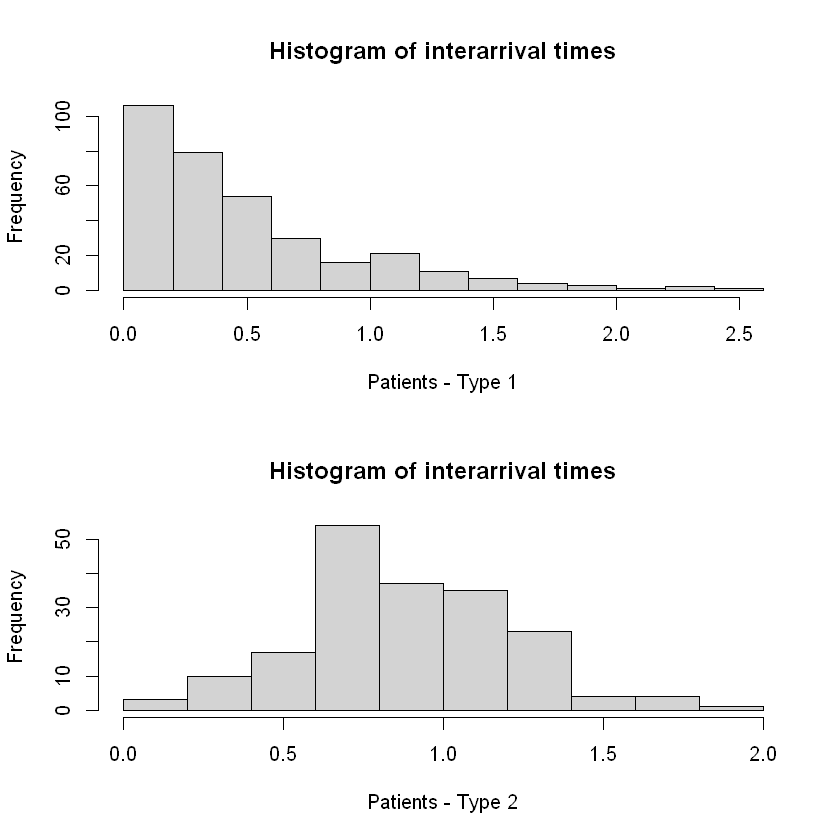

In [12]:
p1$bwArrive <- ave(p1$Time, p1$Date, FUN = function(x) c(NA, diff(x)))
p2$bwArrive <- ave(p2$Time, p2$Date, FUN = function(x) c(NA, diff(x)))

# Histograms of interarrival times
par(mfrow = c(2, 1), bg = "white")

hist(p1$bwArrive,
     main = "Histogram of interarrival times",
     xlab = "Patients - Type 1")

hist(p2$bwArrive,
     main = "Histogram of interarrival times",
     xlab = "Patients - Type 2")

A simple visual analysis of the data encourages us to believe the interarrival times of patients of type 1 are distributed according to an Exponential distribution. Such claim does not seem to easily hold for the histogram of the second type of patients. 

Gamma distributions are generalization of the Exponential distribution, it could be valuable to consider a Gamma distribution as well. Using Monte Carlo simulation, we test the null hypothesis that the variables are Gamma distributed.

In [13]:
test.gamma(p1$bwArrive[!is.na(p1$bwArrive)])
test.gamma(p2$bwArrive[!is.na(p2$bwArrive)])

stat,p.value
<dbl>,<dbl>
956.0528,0.3506


stat,p.value
<dbl>,<dbl>
2.399733e+13,0.1456


The (Chi-Squared) tests above all fail to reject the null and thus we can conclude that the variables are likely Gamma distributed. This result does not exclude the possibility that the interarrival times of patients of type 1 are Exponentially distributed since for small parameters, Gamma and Exponential behave similarly.

# Mean of interarrivals - Bootstrap

In [14]:
p1.ia <- boot.mean(B, p1$bwArrive[!is.na(p1$bwArrive)])
ci(p1.ia)



|     mean|        se|
|--------:|---------:|
| 0.501541| 0.0249255|




|      |        CI|
|:-----|---------:|
|2.5%  | 0.4541485|
|97.5% | 0.5518821|

In [15]:
p2.ia <- boot.mean(B, p2$bwArrive[!is.na(p2$bwArrive)])
ci(p2.ia)



|      mean|        se|
|---------:|---------:|
| 0.8874184| 0.0241738|




|      |        CI|
|:-----|---------:|
|2.5%  | 0.8400532|
|97.5% | 0.9354801|

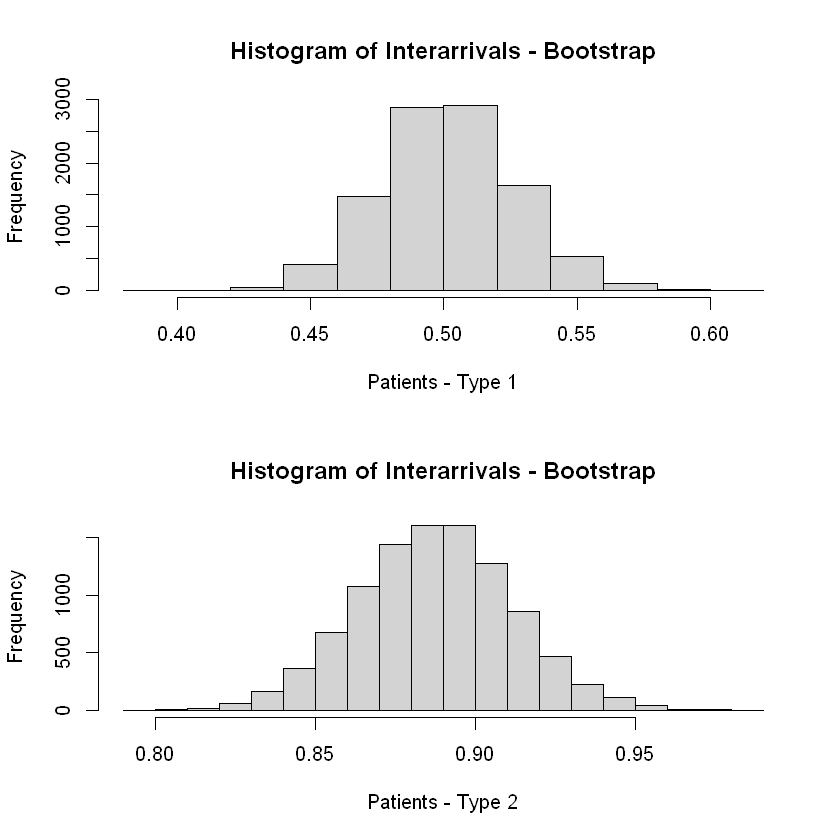

In [16]:
par(mfrow = c(2, 1), bg = "white")
hist(p1.ia,
     main = "Histogram of Interarrivals - Bootstrap",
     xlab = "Patients - Type 1")

hist(p2.ia,
     main = "Histogram of Interarrivals - Bootstrap",
     xlab = "Patients - Type 2")

## Variance of interarrivals - Bootstrap

In [17]:
p1.iaV <- boot.var(B, p1$bwArrive[!is.na(p1$bwArrive)])
p2.iaV <- boot.var(B, p2$bwArrive[!is.na(p2$bwArrive)])



|      mean|        se|
|---------:|---------:|
| 0.2119452| 0.0244887|


|      mean|        se|
|---------:|---------:|
| 0.1081031| 0.0111324|


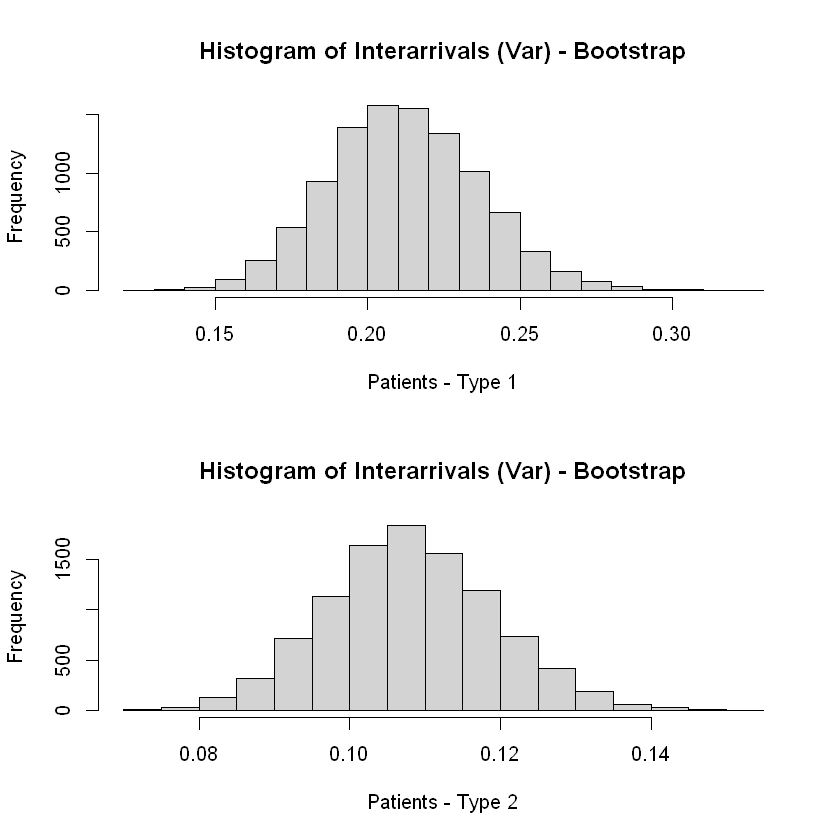

In [18]:
par(mfrow = c(2, 1), bg = "white")
hist(p1.iaV,
     main = "Histogram of Interarrivals (Var) - Bootstrap",
     xlab = "Patients - Type 1")

hist(p2.iaV,
     main = "Histogram of Interarrivals (Var) - Bootstrap",
     xlab = "Patients - Type 2")

## Monte Carlo (Test choice of distribution)

Be careful when interpreting the results from this function (-> Not sure if well-implemented).

In [19]:
# Test whether Exponentially distributed
n <- nrow(p1)
rate <- 1 / mean(p1.ia)
theta <- mean(p1.ia)

monte.carlo(p.dist = rexp(n, rate), theta = theta)

[1] 0.953

In [20]:
# Test whether Gamma distributed
n <- nrow(p2)
m <- mean(p2.ia)
v <- var(p2.ia) 
shape <- m ^ 2 / v
scale <- v / m
theta <- mean(p2.ia)

monte.carlo(p.dist = rgamma(n, shape, scale = scale), theta = theta)

[1] 0.935

## Hourly arrivals

Since there is not much daily arrival data, one can take a look at whether hourly arrival behave according to a Poisson distribution.

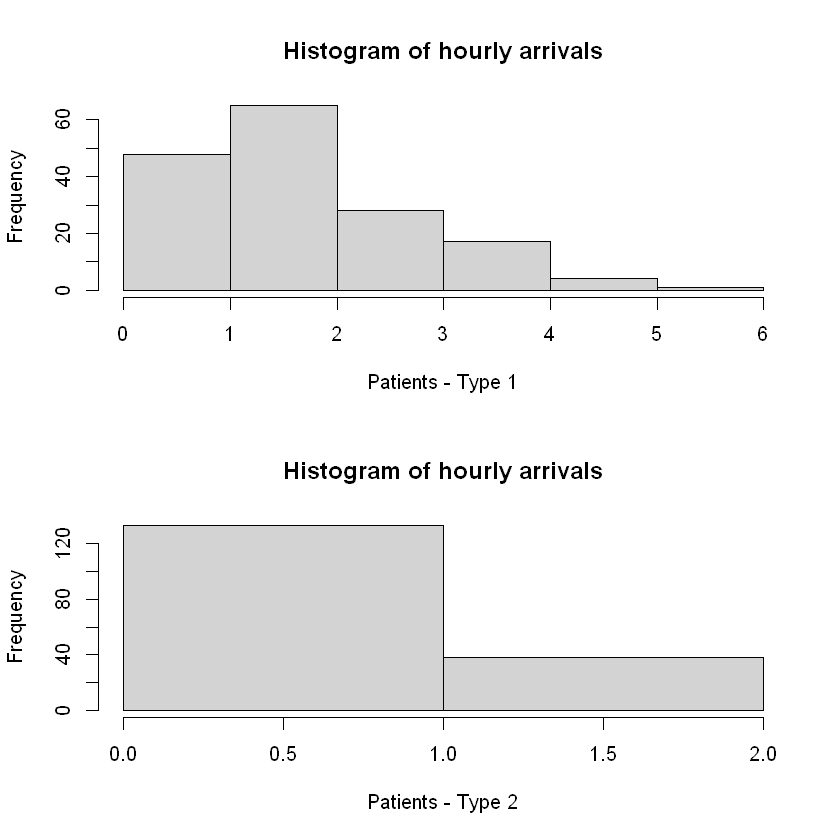

In [21]:
# Compute hourly arrivals per day
p1.hd <- hourly.day(p1)
p2.hd <- hourly.day(p2)

par(mfrow = c(2, 1), bg = "white")
hist(p1.hd$count,
    breaks = 0:ceiling(max(p1.hd$count)),
    main = "Histogram of hourly arrivals",
    xlab = "Patients - Type 1"
    )
hist(p2.hd$count,
    breaks = 0:ceiling(max(p2.hd$count)),
    main = "Histogram of hourly arrivals",
    xlab = "Patients - Type 2"
    )

Unsurprisingly, the second type of patients do not appear to have a distribution that resembles a Poisson distribution as there are not enough oberservations that lie above the average (i.e. above 2, a Poisson distribution would have some observations).

These suspicions are confirmed by the Monte Carlo (Chi-Squared) test for the Poisson distribution below. While we fail to reject the null for patients of type 1, we reject it at the 5% critical level for those of type 2.

In [22]:
test.pois(p1.hd$count)
test.pois(p2.hd$count)

stat,p.value
<dbl>,<dbl>
15.17468,0.1249


stat,p.value
<dbl>,<dbl>
82.88693,0.0071


In [23]:
p1.hdc <- boot.mean(B, p1.hd$count)
p2.hdc <- boot.mean(B, p2.hd$count)



|     mean|        se|
|--------:|---------:|
| 2.184959| 0.0849143|


|     mean|        se|
|--------:|---------:|
| 1.222421| 0.0316833|


The histogram below look weird, unaware whether I should be concerned.

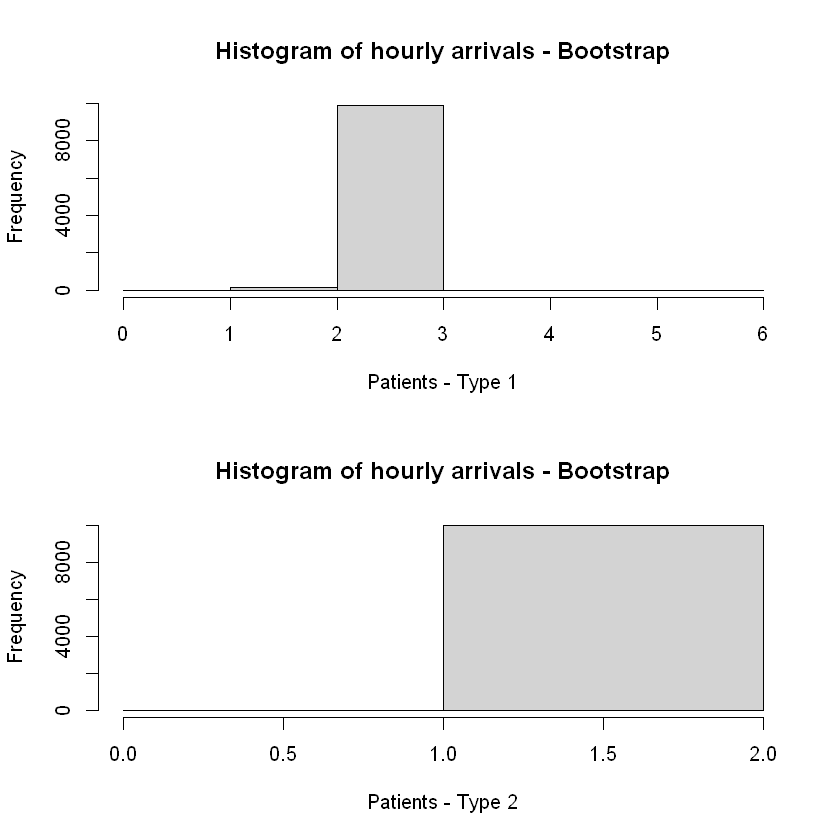

In [24]:
par(mfrow = c(2, 1), bg = "white")
hist(p1.hdc,
    breaks = 0:ceiling(max(p1.hd$count)),
    main = "Histogram of hourly arrivals - Bootstrap",
    xlab = "Patients - Type 1"
    )
hist(p2.hdc,
    breaks = 0:ceiling(max(p2.hd$count)),
    main = "Histogram of hourly arrivals - Bootstrap",
    xlab = "Patients - Type 2"
    )

One characteristic of a simple Poisson random variable is that the moving average of the variable shows no trend. We can visually check this below.

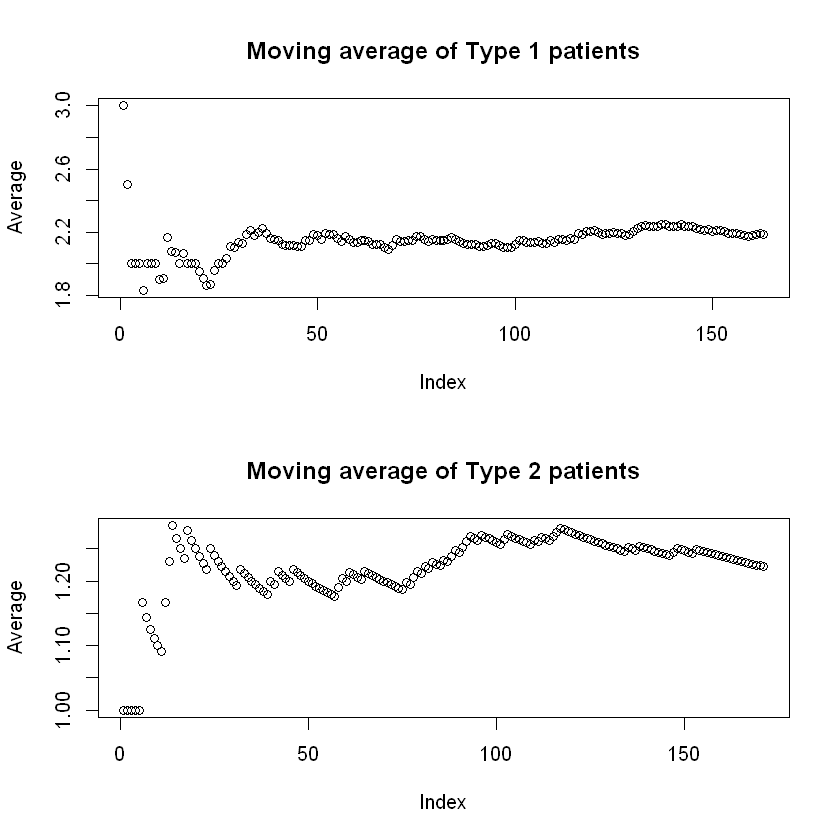

In [25]:
n <- length(p1.hd$count)
ma1.pois <- rep(NA, n)

for(i in 1:n){
    ma1.pois[i] <- mean(p1.hd$count[1:i]) 
}

n <- length(p2.hd$count)
ma2.pois <- rep(NA, n)

for(i in 1:n){
    ma2.pois[i] <- mean(p2.hd$count[1:i]) 
}

par(mfrow = c(2, 1), bg = "white")
plot(ma1.pois,
     main = "Moving average of Type 1 patients",
     ylab = "Average")
plot(ma2.pois,
     main = "Moving average of Type 2 patients",
     ylab = "Average")

The moving average of the first type of patient appears to remain constant as the sample size increases but the same can hardly be said about the Type 2 patients.

The combination of the Monte Carlo Poisson test and the plot above leads us to conclude that the interarrival times of the second type of patients cannot be modelled by an Exponential variable.

Since the Gamma distribution is a generalization of the Exponential distribution, let's have a quick look at a Gamma random variable with similar parameters.

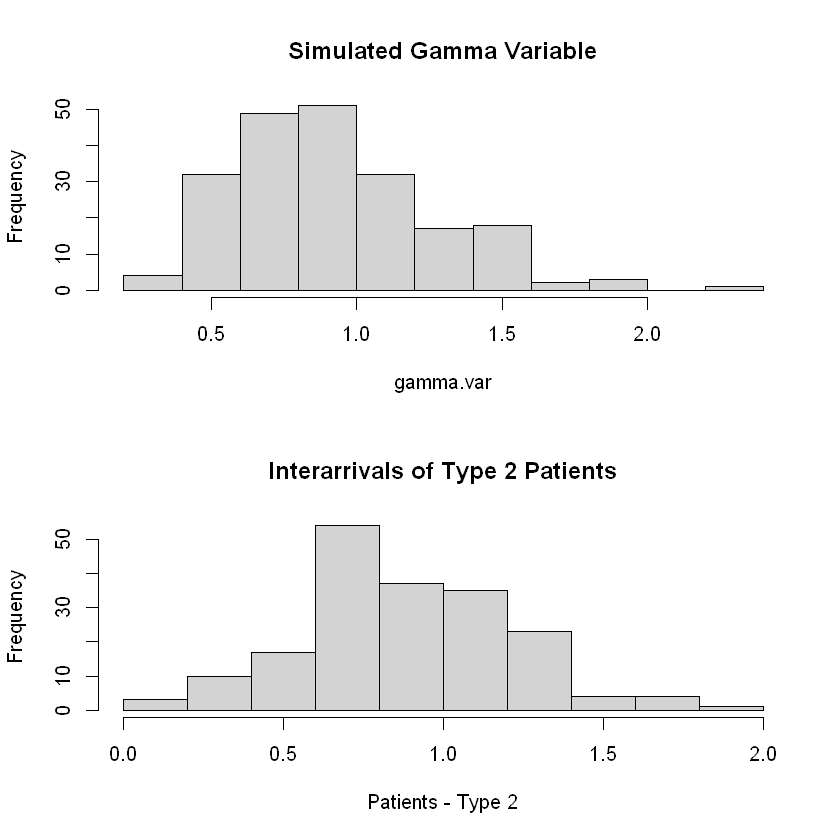

In [36]:
n <- length(p2$bwArrive)
m <- mean(p2.ia)
v <- mean(p2.iaV)

shape <- m ^ 2 / v
scale <- v / m
gamma.var <- rgamma(n, shape, scale = scale)

par(mfrow = c(2, 1), bg = "white")
hist(gamma.var,
     main = "Simulated Gamma Variable")
hist(p2$bwArrive[!is.na(p2$bwArrive)],
    main = "Interarrivals of Type 2 Patients",
    xlab = "Patients - Type 2")

## Slot Selection

We select a time slots of 35 minutes for patients of type 1 and one of 60 minutes for patients of type 2. 

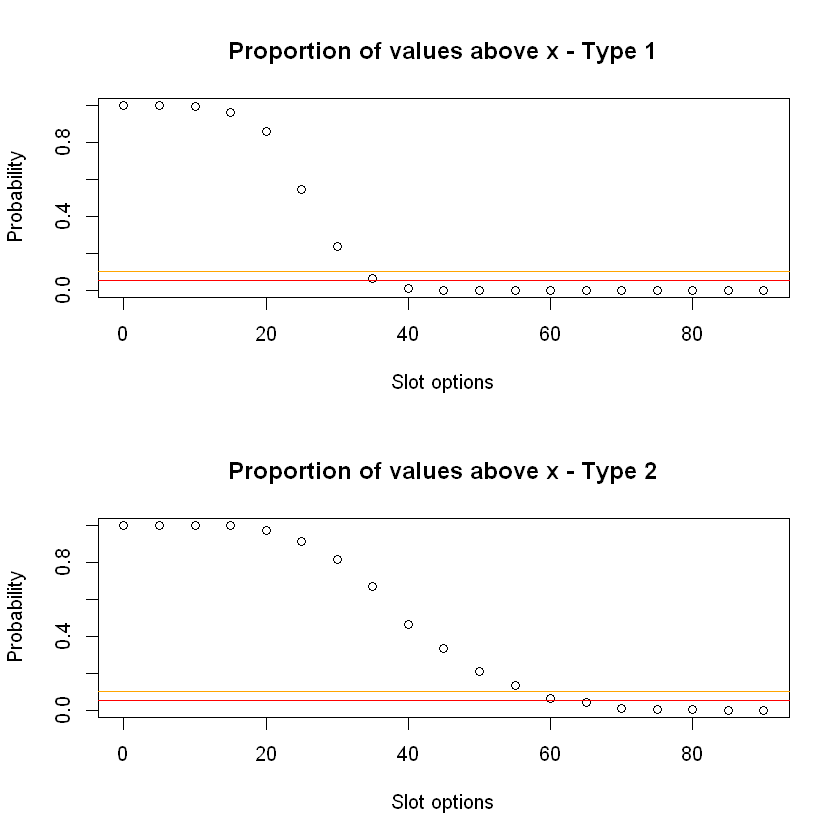

In [ ]:
slot.options <- seq(0, 90, by = 5) / 60
n <- length(slot.options)
slot1.bp <- rep(NA, n)

p1.bdur <- sample(x = p1$Duration, 
                  size = B * length(p1$Duration), 
                  replace = TRUE)

for(i in 1:n){
    slot1.bp[i] <- 1 - edf(p1.bdur, slot.options[i])
}

p1.slot <- data.frame(slots = slot.options * 60,
           boot.p = round(slot1.bp, 4))

slot.options <- seq(0, 90, by = 5) / 60
n <- length(slot.options)
slot2.bp <- rep(NA, n)

p2.bdur <- sample(x = p2$Duration, 
                  size = B * length(p2$Duration), 
                  replace = TRUE)

for(i in 1:n){
    slot2.bp[i] <- 1 - edf(p2.bdur, slot.options[i])
}

p2.slot <- data.frame(slots = slot.options * 60,
           boot.p = round(slot2.bp, 4))

par(mfrow = c(2, 1), bg = "white")
plot(x = slot.options * 60, y = slot1.bp,
     main = "Proportion of values above x - Type 1",
     xlab = "Slot options", ylab = "Probability")
abline(a = 0.1, b = 0, col = 'orange')
abline(a = 0.05, b = 0, col = 'red')

plot(x = slot.options * 60, y = slot2.bp,
     main = "Proportion of values above x - Type 2",
     xlab = "Slot options", ylab = "Probability")
abline(a = 0.1, b = 0, col = 'orange')
abline(a = 0.05, b = 0, col = 'red')

## Optimization

In [79]:
# Global parameters
days <- 20
start <- 8.00
end <- 17.00

# Type 1 parameters
m1 <- mean(p1.d)
v1 <- mean(p1.dV)
ia1 <- mean(p1.ia)
rate <- 1 / ia1
slot1 <- 35

# Type 2 parameters
m <- mean(p2.d)
v <- mean(p2.dV)
shape.d <- m ^ 2 / v
scale.d <- v / m

m <- mean(p2.ia)
v <- mean(p2.iaV)
shape.ia <- m ^ 2 / v
scale.ia <- v / m
slot2 <- 60


T1 <- data.frame()
T2 <- data.frame()


for(i in 1:days){

time1 <- c(start)
last <- length(time1)
while(time1[last] < end){
    last <- length(time1)
    new <- time1[last] + rexp(1, rate)
    time1 <- append(time1, round(new, 2), after = length(time1))
}

time2 <- c(start)
last <- length(time2)
while(time2[last] < end){
    last <- length(time2)
    new <- time2[last] + rgamma(1, shape.ia, scale = scale.ia)
    time2 <- append(time2, round(new, 2), after = length(time2))
}

# Remove start time and times after 17.00
time1 <- time1[start < time1 & time1 <= end]
time2 <- time2[start < time2 & time2 <= end]

n1 <- length(time1)
n2 <- length(time2)

T1 <- rbind(T1, data.frame(Date = i, Time = time1, 
                           Duration = rnorm(n1, m1, sqrt(v1)), PatientType = "Type 1"))
T2 <- rbind(T2, data.frame(Date = i, Time = time2,
                           Duration = rgamma(n2, shape.d, scale = scale.d),
                           PatientType = "Type 2"))

}

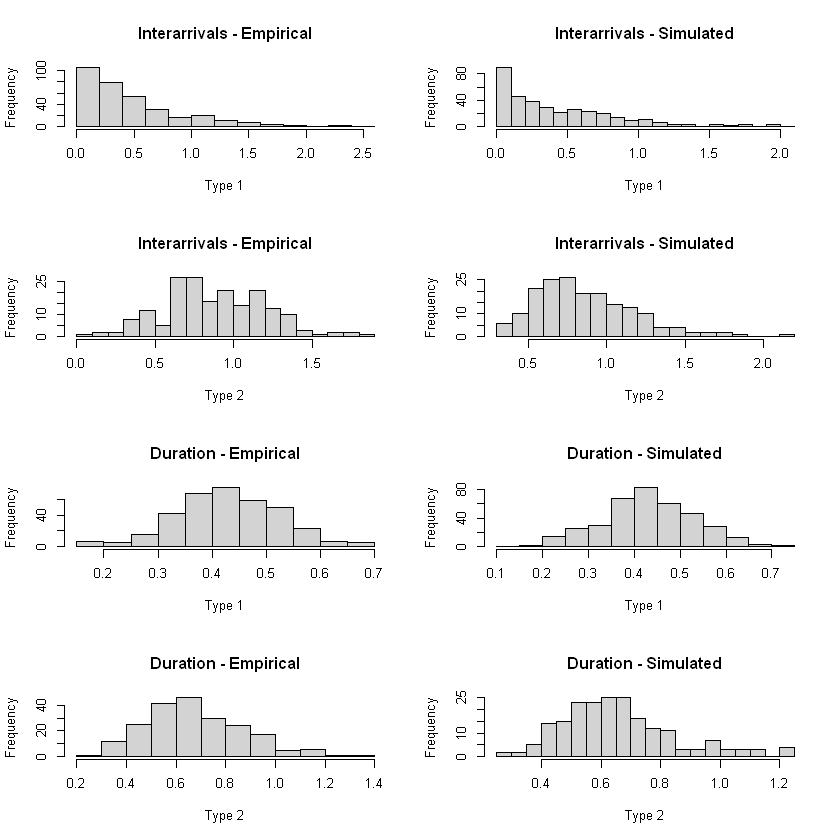

In [80]:
T1$ia <- ave(T1$Time, T1$Date, FUN = function(x) c(NA, diff(x)))
T2$ia <- ave(T2$Time, T2$Date, FUN = function(x) c(NA, diff(x)))

breaks <- 15

par(mfrow = c(4, 2), bg = "white")
hist(p1$bwArrive, breaks = breaks, 
main = "Interarrivals - Empirical",
xlab = "Type 1")
hist(T1$ia, breaks = breaks, 
main = "Interarrivals - Simulated",
xlab = "Type 1")
hist(p2$bwArrive, breaks = breaks, 
main = "Interarrivals - Empirical",
xlab = "Type 2")
hist(T2$ia, breaks = breaks, 
main = "Interarrivals - Simulated",
xlab = "Type 2")
hist(p1$Duration, breaks = breaks, 
main = "Duration - Empirical",
xlab = "Type 1")
hist(T1$Duration, breaks = breaks, 
main = "Duration - Simulated",
xlab = "Type 1")
hist(p2$Duration, breaks = breaks, 
main = "Duration - Empirical",
xlab = "Type 2")
hist(T2$Duration, breaks = breaks, 
main = "Duration - Simulated",
xlab = "Type 2")

In [83]:
sim.data <- rbind(T1, T2)
sim.data <- sim.data[order(sim.data$Date, sim.data$Time), ]
sim.data$id <- 1:nrow(sim.data)
sim.data

,Date,Time,Duration,PatientType,ia,id
,<int>,<dbl>,<dbl>,<chr>,<dbl>,<int>
1,1,8.08,0.3428443,Type 1,NA,1
378,1,8.52,0.6825580,Type 2,NA,2
2,1,8.80,0.3304313,Type 1,0.72,3
379,1,9.02,0.8081705,Type 2,0.50,4
3,1,10.01,0.3745092,Type 1,1.21,5
4,1,10.25,0.3546108,Type 1,0.24,6
380,1,10.36,0.6426910,Type 2,1.34,7
5,1,10.58,0.3826504,Type 1,0.33,8
6,1,10.68,0.3944936,Type 1,0.10,9
